In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#plt.style.use('seaborn-whitegrid') # set style (colors, background, size, gridlines etc.) # ggplot
plt.rcParams['figure.figsize'] = 8, 4 # set default size of plots
plt.rcParams.update({'font.size': 10})

import scraping_class_chrome
logfile = 'log.txt' ## name your log file.
connector = scraping_class_chrome.Connector(logfile, connector_type='selenium', path2selenium='/Users/Messias/Documents/Polit/9. semester/Social data science/chromedriver') # insert own chromedriver-path

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

#pip install cpi
import cpi # inflation adjuster
#cpi.update()

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

## Web Scraping

In [ ]:
import requests
session = requests.session()
session.headers['email'] = 'zpx171@alumni.ku.dk'
session.headers['name'] = 'Mathias Ellehauge'
session.headers

Now we proceed to scraping the Rotten Tomatoes website. We wished to automate the process by creating a loop running over the function below that scraped each url we had retrieved, however the loop stopped each time we had scraped one genre. Thus we proceeded to scrape each site manually for urls. The code is below, but we have collapsed all cell except the first one to ease the reading of the notebook.

In [ ]:
def get_urls(genre):
    
    connector = scraping_class_chrome.Connector(logfile, connector_type='selenium', path2selenium='/Users/Messias/Documents/Polit/9. semester/Social data science/chromedriver')

    url = f'https://www.rottentomatoes.com/browse/dvd-streaming-all?minTomato=0&maxTomato=100&services=amazon;hbo_go;itunes;netflix_iw;vudu;amazon_prime;fandango_now&genres={genre}&sortBy=release'
    connector.get(url, 'RT_sel')
    
    driver = connector.browser
    time.sleep(20)
    
    urls = []
    
    while True:
        try:
            showMoreButton = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR,'#show-more-btn > button')))
            showMoreButton.click()
            
            html = driver.page_source
            soup = BeautifulSoup(html, 'lxml')
        
            for a in soup.find_all('a', attrs={'href': re.compile("^/m/")}): 
                if a.text: 
                    urls.append(a['href'])
        except:
            driver.quit()
    
    return urls

In [ ]:
genres = [1,2,4,5,6,8,9,10,11,13,18,14]

list_of_links = []
for i in genres:
    list_of_links.append(get_urls(i))

In [ ]:
# example of scraping procedure. We just proceeded with running this for each number in the genres list defined above
url = 'https://www.rottentomatoes.com/browse/dvd-streaming-all?minTomato=0&maxTomato=100&services=amazon;hbo_go;itunes;netflix_iw;vudu;amazon_prime;fandango_now&genres=1&sortBy=release'
connector.get(url, 'RT_sel')

driver = connector.browser
time.sleep(20)

while True:
    try:
        showMoreButton = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR,'#show-more-btn > button')))
        showMoreButton.click()
    except None:
        print('loop ended')

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

list_of_urls = []
for a in soup.find_all('a', attrs={'href': re.compile("^/m/")}): 
    if a.text: 
        list_of_urls.append(a['href'])

In [ ]:
# create urls

df = pd.DataFrame(list_of_urls,index=range(len(list_of_urls)))
df1 = df.drop_duplicates()
list_of_suffixes = list(df1[0])

list_of_links = []
base = 'https://www.rottentomatoes.com'

for i in list_of_suffixes:
    list_of_links.append(base+i)

In [ ]:
def scrape_RT(url):
    
    connector.get(url,'RT')
    
    driver = connector.browser
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    scores_node = soup.find_all('span',{'class':'mop-ratings-wrap__percentage'})
    driver.implicitly_wait(20)
    scores = []
    
    for i in range(len(scores_node)):
        
        if len(scores_node)==2:
            scores.append(scores_node[i].text.strip())
            
        elif len(scores_node)==1:
            scores.append(scores_node[i].text.strip())
            scores.append('Nan')
            
        else:
            scores.append('Nan')
            scores.append('Nan')
        
    movie_title = soup\
                    .find('h1')\
                    .text\
                    .strip()
    
    return [movie_title, scores[0], scores[1]]

In [ ]:
for link in tqdm(list_of_links):
    try:
        list_of_scores.append(scrape_RT(link))
    except:
        pass

In [ ]:
with open('links.txt', 'w') as f:
    for item in list_of_links:
        f.write("%s\n" % item)

In [ ]:
links = open('links.txt')
links_list = []
for item in links:
    links_list.append(item)
len(links_list)

In [ ]:
with open('RT.txt', 'w') as f:
    for item in list_of_scores:
        f.write("%s\n" % item)

In [ ]:
cols = ['title','tomatometer_score','audience_score']
df2 = pd.DataFrame(list_of_scores, index=range(len(list_of_scores)), columns=cols)
df2.to_csv('RT.csv',index=False)

## Data processing

In [134]:
# read in IMDb dataset
movies = pd.read_csv('IMDb movies.csv')

#### IMDb - Remove duplicates and all years before 1990

In [135]:
movies_90 = movies[movies.year >= 1990] # (53368, 22)
movies_90['title'] = movies_90['title'].astype(str)
movies_90 = movies_90.drop_duplicates(subset = 'title')

#### RT - Remove duplicates 

In [136]:
# read in Rotten Tomatoes dataset
df_RT = pd.read_csv('RT.csv').drop_duplicates(subset = 'title')

# merge datasets and drop duplicates
df_90 = pd.merge(movies_90,df_RT,how='inner',on='title')
df_90 = df_90.drop_duplicates()

In [137]:
# remove NaN 
df_90_income = df_90.dropna(subset = ['worlwide_gross_income']).reset_index(drop=True).drop_duplicates()

# show DataFrame
df_90_income

imdb_title_id                   title          original_title  year  \
0        tt0035423          Kate & Leopold          Kate & Leopold  2001   
1        tt0098994    After Dark, My Sweet    After Dark, My Sweet  1990   
2        tt0099005             Air America             Air America  1990   
3        tt0099012                   Alice                   Alice  1990   
4        tt0099018         Almost an Angel         Almost an Angel  1990   
...            ...                     ...                     ...   ...   
7245     tt9109306          The Final Wish          The Final Wish  2018   
7246     tt9206798             All Is True             All Is True  2018   
7247     tt9352926    The Sound of Silence    The Sound of Silence  2019   
7248     tt9354944                    Jexi                    Jexi  2019   
7249     tt9356952  The Death of Dick Long  The Death of Dick Long  2019   

     date_published                      genre  duration country  \
0        2002-04-05   Comedy, Fantasy, Romance       118     USA   
1        1990-08-24      Crime, Drama, Mystery       114     USA   
2        1991-02-22        Action, Comedy, War       113     USA   
3        1991-01-10            Comedy, Romance       106     USA   
4        1990-12-27              Comedy, Drama        95     USA   
...             ...                        ...       ...     ...   
7245     2019-01-24                     Horror        95     USA   
7246     2019-02-08  Biography, Drama, History       101      UK   
7247     2019-09-13                      Drama        85     USA   
7248     2019-10-11                     Comedy        84     USA   
7249     2019-09-27       Comedy, Crime, Drama       100     USA   

                language                director  ... avg_vote  votes  \
0        English, French           James Mangold  ...      6.4  75298   
1                English             James Foley  ...      6.6   3019   
2           English, Lao      Roger Spottiswoode  ...      5.8  25683   
3     English, Cantonese             Woody Allen  ...      6.6  12574   
4                English            John Cornell  ...      5.5   3760   
...                  ...                     ...  ...      ...    ...   
7245             English    Timothy Woodward Jr.  ...      4.2   2342   
7246             English         Kenneth Branagh  ...      6.1   1956   
7247             English        Michael Tyburski  ...      5.3    426   
7248             English  Jon Lucas, Scott Moore  ...      6.6   3674   
7249             English        Daniel Scheinert  ...      6.3   1602   

          budget usa_gross_income  worlwide_gross_income  metascore  \
0     $ 48000000       $ 47121859             $ 76019048       44.0   
1            NaN        $ 2678414              $ 2678414       78.0   
2     $ 35000000       $ 31053601             $ 33461269       33.0   
3     $ 12000000        $ 7331647              $ 7331647       67.0   
4     $ 25000000        $ 6939946              $ 6939946        NaN   
...          ...              ...                    ...        ...   
7245         NaN          $ 25183                $ 82959        NaN   
7246         NaN        $ 1200481              $ 3019143       59.0   
7247         NaN          $ 20013                $ 21994       66.0   
7248   $ 5000000        $ 6546159              $ 7257918       39.0   
7249         NaN          $ 36856                $ 36856       69.0   

     reviews_from_users reviews_from_critics tomatometer_score  audience_score  
0                 330.0                127.0               50%             62%  
1                  46.0                 28.0               82%             61%  
2                  49.0                 28.0               13%             34%  
3                  65.0                 59.0               75%             57%  
4                  26.0                 10.0               29%             48%  
...                 ...                  ...               

#### Cleaning dataset and adjusting income and budget for inflation (CPI)

In [138]:
def inflate_column(data, column):
    '''Inflate monetary figures from a given year to their 2018 values'''
    return data.apply(lambda x: cpi.inflate(x[column], x.year), axis=1)

In [139]:
# remove all currency signs and dropping movies which revenue is not in dollars
df_90_income['worldwide_gross_income'] = df_90_income['worlwide_gross_income']\
                                        .apply(lambda x:x[1:] if x and x[:1]== '$' else None)

df_90_income = df_90_income.drop('worlwide_gross_income', axis=1)

# drop NaN for worldwide gross income 
df_90_income = df_90_income.dropna(subset = ['worldwide_gross_income'])

In [140]:
# repeat for budget
df_90_income = df_90_income.dropna(subset = ['budget'])
df_90_income['budget'] = df_90_income['budget'].apply(lambda x:x[1:] if x and x[:1]== '$' else None)

In [141]:
df_90_income = df_90_income.reset_index(drop=True).drop_duplicates()

# convert wgi to integer and drop years before 2019
df_90_income['worldwide_gross_income'] = df_90_income['worldwide_gross_income'].astype(int)
df_90_income = df_90_income[df_90_income.year <= 2018]

# inflate wgi to 2018 prices
df_90_income['adjusted_wgi'] = inflate_column(df_90_income, 'worldwide_gross_income')


# repeat for budget
df_budget = df_90_income.dropna(subset = ['budget']).copy()
df_budget.budget = df_budget.budget.astype(int)
df_budget['adjusted_budget'] = inflate_column(df_budget, 'budget')

# calculate net income
df_budget['net_income'] = df_budget.adjusted_wgi - df_budget.adjusted_budget

df = df_budget.reset_index(drop=True)
df # show

imdb_title_id            title   original_title  year date_published  \
0        tt0035423   Kate & Leopold   Kate & Leopold  2001     2002-04-05   
1        tt0099005      Air America      Air America  1990     1991-02-22   
2        tt0099012            Alice            Alice  1990     1991-01-10   
3        tt0099018  Almost an Angel  Almost an Angel  1990     1990-12-27   
4        tt0099044  Another 48 Hrs.  Another 48 Hrs.  1990     1990-09-21   
...            ...              ...              ...   ...            ...   
4599     tt7468616         The Boat         The Boat  2018     2019-02-22   
4600     tt7668870        Searching        Searching  2018     2018-08-31   
4601     tt7690670         Superfly         Superfly  2018     2018-09-14   
4602     tt7738450     Thunder Road     Thunder Road  2018     2019-05-31   
4603     tt7784604       Hereditary       Hereditary  2018     2018-06-15   

                         genre  duration      country  \
0     Comedy, Fantasy, Romance       118          USA   
1          Action, Comedy, War       113          USA   
2              Comedy, Romance       106          USA   
3                Comedy, Drama        95          USA   
4        Action, Comedy, Crime        93          USA   
...                        ...       ...          ...   
4599         Mystery, Thriller       100    UK, Malta   
4600  Drama, Mystery, Thriller       102  Russia, USA   
4601   Action, Crime, Thriller       116          USA   
4602             Comedy, Drama        92          USA   
4603    Drama, Horror, Mystery       127          USA   

                         language            director  ... usa_gross_income  \
0                 English, French       James Mangold  ...       $ 47121859   
1                    English, Lao  Roger Spottiswoode  ...       $ 31053601   
2              English, Cantonese         Woody Allen  ...        $ 7331647   
3                         English        John Cornell  ...        $ 6939946   
4              English, Cantonese         Walter Hill  ...       $ 80818974   
...                           ...                 ...  ...              ...   
4599                      English   Winston Azzopardi  ...              NaN   
4600                      English     Aneesh Chaganty  ...       $ 26020957   
4601  English, Spanish, Cantonese         Director X.  ...       $ 20545116   
4602                      English        Jim Cummings  ...              NaN   
4603             English, Spanish           Ari Aster  ...       $ 44069456   

     metascore reviews_from_users reviews_from_critics  tomatometer_score  \
0         44.0              330.0                127.0                50%   
1         33.0               49.0                 28.0                13%   
2         67.0               65.0                 59.0                75%   
3          NaN               26.0                 10.0                29%   
4         23.0               71.0                 31.0                18%   
...        ...                ...                  ...                ...   
4599       NaN               51.0                  6.0                78%   
4600      71.0              985.0                279.0                92%   
4601      52.0              118.0                 60.0                50%   
4602      79.0               88.0                 87.0                96%   
4603      87.0             2827.0                450.0                89%   

      audience_score  worldwide_gross_income  adjusted_wgi  adjusted_budget  \
0                62%                76019048  1.097391e+08     6.929156e+07   
1                34%                33461269  6.545224e+07     6.846209e+07   
2                57%                 7331647  1.434114e+07     2.347272e+07   
3                48%                 6939946  1.357495e+07     4.890149e+07   
4                35%               153518974  3.002923e+08     7.433027e+07   
...              ...                     ...   

In [142]:
# Converting Rotten Tomatoes scores to floats
df['tomatometer_score'] = df['tomatometer_score'].replace({'\%':''}, regex = True)
df['audience_score'] = df['audience_score'].replace({'\%':''}, regex = True)

df['tomatometer_score']= df['tomatometer_score'].astype(float)
df['audience_score']= df['audience_score'].astype(float)

#### Calculating average scores for directors and writers

In [143]:
writers = list(df['writer'].values)
director_scores = []
a = {}
for director in tqdm(directors):
    a[director] = pd.DataFrame(df[df['director'].str.contains(director)]) # 
    director_scores.append([director,
                           a[director]['avg_vote'].mean(),
                           a[director]['metascore'].mean(),
                           a[director]['tomatometer_score'].mean(),
                           a[director]['audience_score'].mean()])

In [144]:
cols = ['director', 'director_imdb', 'director_metascore', 'director_tomatometer', 'director_audience']
df_director = pd.DataFrame(director_scores, index=range(len(director_scores)),columns=cols)

In [145]:
len(directors)

4354

In [146]:
#writers = list(df.dropna(subset = ['writer'])['writer'].values)
#writers = list(df['writer'].values)
df = df.dropna(subset = ['writer'])

In [147]:
writers = list(df['writer'].values)
writer_scores = []
a = {}
for writer in tqdm(writers):
    
    a[writer] = pd.DataFrame(df[df['writer'].str.contains(writer)])
    writer_scores.append([writer,
                           a[writer]['avg_vote'].mean(),
                           a[writer]['metascore'].mean(),
                           a[writer]['tomatometer_score'].mean(),
                           a[writer]['audience_score'].mean()])

In [148]:
cols = ['writer', 'writer_imdb', 'writer_metascore', 'writer_tomatometer', 'writer_audience']
df_writer = pd.DataFrame(writer_scores, index=range(len(writer_scores)),columns=cols)
df_writer

writer  writer_imdb  writer_metascore  \
0         Steven Rogers, James Mangold     6.400000            44.000   
1      Christopher Robbins, John Eskow     5.800000            33.000   
2                          Woody Allen     6.863158            58.625   
3                           Paul Hogan     5.150000            37.000   
4      Roger Spottiswoode, Walter Hill     5.900000            23.000   
...                                ...          ...               ...   
4598  Joe Azzopardi, Winston Azzopardi     5.300000               NaN   
4599      Aneesh Chaganty, Sev Ohanian     7.700000            71.000   
4600                          Alex Tse     6.350000            54.000   
4601                      Jim Cummings     7.100000            79.000   
4602                         Ari Aster     7.300000            87.000   

      writer_tomatometer  writer_audience  
0              50.000000        62.000000  
1              13.000000        34.000000  
2              62.631579        59.947368  
3              20.000000        36.500000  
4              18.000000        35.000000  
...                  ...              ...  
4598           78.000000        63.000000  
4599           92.000000        87.000000  
4600           57.500000        58.500000  
4601           96.000000        93.000000  
4602           89.000000        67.000000  

[4603 rows x 5 columns]

In [154]:
df = pd.merge(df, df_director, how='left', on='director').drop_duplicates().reset_index(drop=True)
df = pd.merge(df, df_writer, how='left', on='writer').drop_duplicates().reset_index(drop=True)


year     duration     avg_vote         votes        budget  \
count  4603.000000  4603.000000  4603.000000  4.603000e+03  4.603000e+03   
mean   2005.396915   106.512492     6.252618  9.431966e+04  3.400756e+07   
std       7.653568    17.710993     0.986351  1.631129e+05  4.029366e+07   
min    1990.000000    63.000000     1.900000  1.250000e+02  2.500000e+03   
25%    1999.000000    94.000000     5.700000  1.048300e+04  8.000000e+06   
50%    2006.000000   103.000000     6.300000  3.728300e+04  2.000000e+07   
75%    2012.000000   116.000000     6.900000  1.055765e+05  4.400000e+07   
max    2018.000000   271.000000     9.300000  2.159628e+06  3.210000e+08   

         metascore  reviews_from_users  reviews_from_critics  \
count  4011.000000         4603.000000           4602.000000   
mean     52.123909          296.237019            145.672534   
std      17.604504          433.626666            129.458427   
min       1.000000            1.000000              1.000000   
25%      39.000000           72.000000             49.000000   
50%      52.000000          162.000000            109.500000   
75%      65.000000          344.000000            202.000000   
max     100.000000         7029.000000            987.000000   

       tomatometer_score  audience_score  ...  writer_tomatometer_x  \
count        4603.000000     4593.000000  ...           4603.000000   
mean           50.651532       57.789680  ...             50.656756   
std            27.563687       19.634924  ...             25.619186   
min             0.000000        5.000000  ...              0.000000   
25%            27.000000       42.000000  ...             30.000000   
50%            50.000000       58.000000  ...             51.000000   
75%            75.000000       74.000000  ...             72.000000   
max           100.000000       99.000000  ...            100.000000   

       writer_audience_x  director_imdb_y  director_metascore_y  \
count        4595.000000      4430.000000           4213.000000   
mean           57.816110         6.279759             52.082132   
std            18.047139         0.812568             14.786842   
min             5.000000         2.100000              1.000000   
25%            44.500000         5.833333             42.200000   
50%            58.500000         6.400000             52.666667   
75%            72.000000         6.800000             62.142857   
max            99.000000         8.500000             96.000000   

       director_tomatometer_y  director_audience_y  writer_imdb_y  \
count             4430.000000          4426.000000    4603.000000   
mean                50.924114            58.322694       6.249477   
std                 22.080168            14.790090       0.929154   
min                  0.000000             9.000000       1.900000   
25%                 35.000000            49.000000       5.700000   
50%                 52.375000            59.666667       6.300000   
75%                 67.666667            68.500000       6.900000   
max                100.000000            97.000000       8.950000   

       writer_metascore_y  writer_tomatometer_y  writer_audience_y  
count         4141.000000           4603.000000        4595.000000  
mean            52.054099             50.656756          57.816110  
std             16.451980             25.619186          18.047139  
min              1.000000              0.000000           5.000000  
25%             40.000000             30.000000          44.500000  
50%             52.000000             51.000000          58.500000  
75%             64.000000             72.000000          72.000000  
max             96.000000            100.000000          99.000000  

[8 rows x 30 columns]

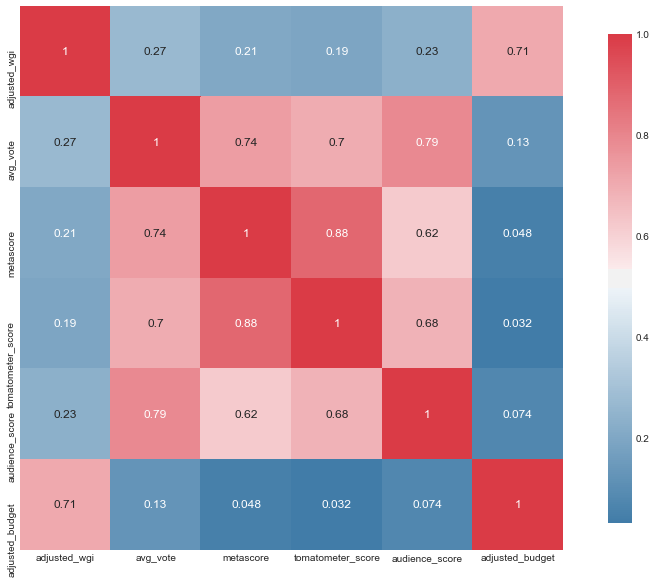

In [197]:
df_corr = df[['adjusted_wgi','avg_vote', 'metascore', 'tomatometer_score', 'audience_score', 'adjusted_budget']]

def plot_correlation_map(df_corr):
    corr = df_corr.corr()
    
    _ , ax = plt.subplots(figsize =(16, 10))
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })


plot_correlation_map(df_corr)
plt.savefig('heatmap.png')

#### Dummies 

In [122]:
df = df.dropna().reset_index(drop=True)
df['date_published'] = df['date_published'].apply(lambda x:pd.Timestamp(x).value if x else 0)
df["season_published"] = df["date_published"].apply(lambda x: pd.to_datetime(x).month)

In [123]:
cols = ["season_published",  'genre'] 
df_dummies = pd.get_dummies(df, drop_first=True, columns=cols).reset_index(drop=True)

In [150]:
dummies_final = df_dummies.drop(['country',"reviews_from_users","reviews_from_critics","worldwide_gross_income","votes","budget","usa_gross_income","imdb_title_id","title","original_title","date_published","duration","year","language","description",'director', 'actors', 'writer', 'production_company',],axis=1)

In [151]:
dummies_final

avg_vote  metascore  tomatometer_score  audience_score  adjusted_wgi  \
0          6.4       44.0               50.0            62.0  1.097391e+08   
1          5.8       33.0               13.0            34.0  6.545224e+07   
2          6.6       67.0               75.0            57.0  1.434114e+07   
3          5.9       23.0               18.0            35.0  3.002923e+08   
4          6.4       67.0               92.0            54.0  1.040784e+08   
...        ...        ...                ...             ...           ...   
3870       7.3       57.0               81.0            82.0  1.227407e+08   
3871       6.8       69.0               91.0            72.0  5.303410e+07   
3872       7.7       71.0               92.0            87.0  7.682939e+07   
3873       5.1       52.0               50.0            46.0  2.115723e+07   
3874       7.3       87.0               89.0            67.0  8.077439e+07   

      adjusted_budget  adjusted_us_income    net_income  net_us_income  \
0        6.929156e+07        6.802390e+07  4.044758e+07  -1.267662e+06   
1        6.846209e+07        6.074270e+07 -3.009850e+06  -7.719392e+06   
2        2.347272e+07        1.434114e+07 -9.131577e+06  -9.131577e+06   
3        7.433027e+07        1.580867e+08  2.259620e+08   8.375647e+07   
4        4.303331e+07        1.040784e+08  6.104506e+07   6.104506e+07   
...               ...                 ...           ...            ...   
3870     4.886975e+07        6.858384e+07  7.387090e+07   1.971409e+07   
3871     1.018120e+07        3.033003e+07  4.285290e+07   2.014883e+07   
3872     8.959454e+05        2.649245e+07  7.593345e+07   2.559651e+07   
3873     1.628992e+07        2.091739e+07  4.867310e+06   4.627472e+06   
3874     1.018120e+07        4.486798e+07  7.059319e+07   3.468679e+07   

      director_imdb  ...  genre_Mystery, Thriller  genre_Romance  \
0          7.157143  ...                        0              0   
1          6.150000  ...                        0              0   
2          6.863158  ...                        0              0   
3          6.066667  ...                        0              0   
4          6.500000  ...                        0              0   
...             ...  ...                      ...            ...   
3870       6.216667  ...                        0              0   
3871       6.800000  ...                        0              0   
3872       7.700000  ...                        0              0   
3873       5.100000  ...                        0              0   
3874       7.300000  ...                        0              0   

      genre_Romance, Comedy, Drama  genre_Romance, Comedy, Musical  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   
...                            ...                             ...   
3870                             0                               0   
3871                             0                               0   
3872                             0                               0   
3873                             0                               0   
3874                             0                               0   

      genre_Romance, Sci-Fi, Thriller  genre_Romance, Thriller  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   0                        0   
...                               ...                      ...   
3870                                0                       

##### Seperating data into features (have greater flexibility for project when predicting)

In [183]:
df_x = dummies_final.drop(['net_income','net_us_income','adjusted_wgi', 'adjusted_us_income'],axis=1)
df_y = dummies_final[['adjusted_wgi']]

In [184]:
df_x.to_csv('inputInfo_X.csv', encoding='utf-8',index=False)

In [185]:
df_y.to_csv('inputInfo_Y.csv', encoding='utf-8',index=False)

In [186]:
x = pd.read_csv("inputInfo_X.csv")
y = pd.read_csv("inputInfo_Y.csv")

In [187]:
# define features to be dropped from given dataset
imdb_features = ['metascore', 'director_metascore', 'writer_metascore', 'tomatometer_score', 'director_tomatometer','writer_tomatometer', 'audience_score', 'director_audience', 'writer_audience']
meta_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'tomatometer_score', 'director_tomatometer','writer_tomatometer', 'audience_score', 'director_audience', 'writer_audience']
tomato_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'metascore', 'director_metascore', 'writer_metascore', 'audience_score', 'director_audience', 'writer_audience'] 
audience_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'metascore', 'director_metascore', 'writer_metascore', 'tomatometer_score', 'director_tomatometer','writer_tomatometer']

In [189]:
# construct datasets for desired features
x_imdb = x.drop(imdb_features,axis=1)
x_meta = x.drop(meta_features,axis=1)
x_tometer = x.drop(tomato_features,axis=1)
x_audience = x.drop(audience_features,axis=1)

# select target
y_norm = np.log(y) # log normalize

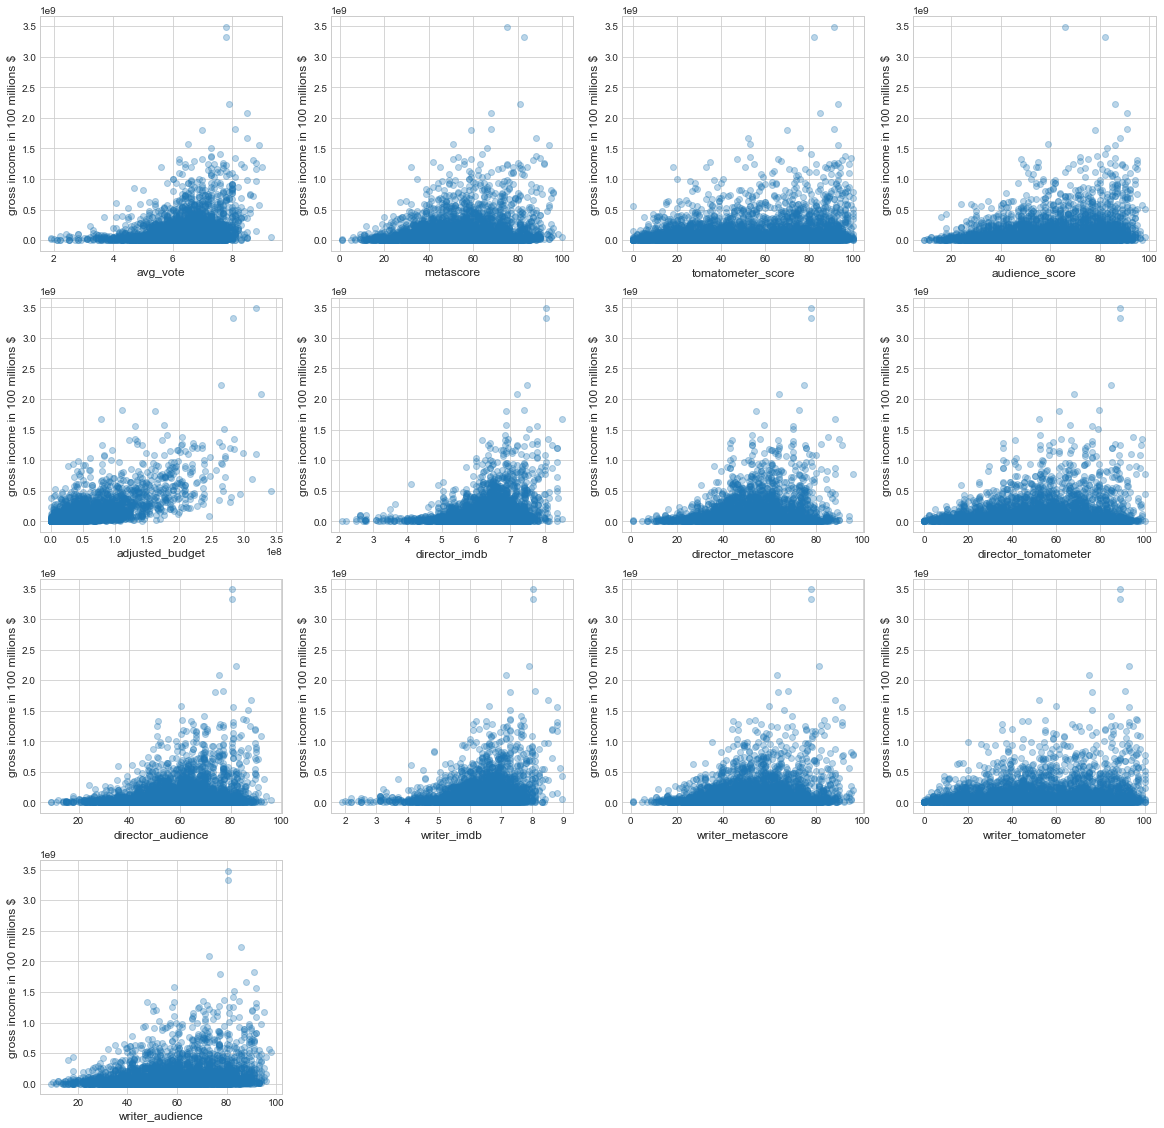

In [202]:
fig = plt.figure(figsize = (20, 25)) # create figure

for index, feature_name in enumerate(x.columns[:13]): # create scatterplot for each of the main features
    ax = fig.add_subplot(5, 4, index+1) 
    ax.scatter(x[feature_name], y, alpha=0.3) 
    ax.set_ylabel('gross income in 100 millions $', size = 12) 
    ax.set_xlabel(feature_name, size = 12) 

plt.savefig('scatters.png')
#plt.show() 


Now we want to build a preliminary model to evaluate baseline performance of each of the datasets in a linear regression.

In [ ]:
# split datasets into set for training and testing
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(x_imdb, y_norm, test_size=1/3, random_state=1)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(x_meta, y_norm, test_size=1/3, random_state=1)
X_train_tometer, X_test_tometer, y_train_tometer, y_test_tometer = train_test_split(x_tometer, y_norm, test_size=1/3, random_state=1)
X_train_audience, X_test_audience, y_train_audience, y_test_audience = train_test_split(x_audience, y_norm, test_size=1/3, random_state=1)